In [1]:
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

In [2]:
MATERIAL_PATH = "../All_mat_new_test_score_with_horz_flat_index.csv"
DATA_PATH = "../../data"

## Start with Anupam's list of materials

In [3]:
material_df = pd.read_csv("../All_mat_new_test_score_with_horz_flat_index.csv", index_col="ID")
print(material_df.shape)
material_df.head()

(5270, 24)


,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,D,E,F,radio,f_orb,sg_sto_group,percentage_flat
ID,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN


In [4]:
# Select flat materials only
flat_df = material_df[material_df.horz_flat_seg > 0]
flat_df.shape

(2005, 24)

## Fingerprint Functions Here
Fingerprint functions take material ID as only input

In [5]:
def calc_gamma_fingerprint(material_id, fingerprint_length, e_range=[-8, 8]):
    global edges
    filename_bands=DATA_PATH+"/bands/"+material_id+'.json'
    if not os.path.isfile(filename_bands):
        print("!!!! No such file %s" % filename_bands)
    bands_dict=json.load(open(filename_bands))

    band_energies = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
    band_energies_gamma = band_energies[:, 0]
    counts, edges = np.histogram(band_energies_gamma, bins=fingerprint_length, range=e_range)
    return counts
    

calc_gamma_fingerprint("2dm-1", 32)

array([0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0,
       0, 0, 1, 0, 1, 2, 0, 1, 1, 0])

In [8]:
def calc_DOS_fingerprint(matid, fingerprint_length, e_range=[-9, 9]):
    # DOS_fingerprint_length; clustering may be sensitive to this! - encoding of sharp peaks is very sensitive to this
    # as if the value is too low, sharp peaks get averaged out and so the flat band corresponding to the peak isnt enconded as being as flat as it is
    
    # create list of energies between which, the DOS value is averaged (ensures fingerprints are same length for all materials)
    energy_bins = np.linspace(e_range[0],e_range[1], fingerprint_length+1)
    
    # HENRY SYSTEM PATHS TO MATERIAL DATA
    #path_db = 'C:/Users/hkpen/MPhys_Project/data extraction+fingerprinting/'
    #DATA_PATH = henry_path_db+'FULL_MATPEDIA_DATA/'
    
    # TOM SYSTEM PATHS TO MATERIAL DATA are set above already

    DOS_dir= DATA_PATH+'/dos/'
    filename_dos=DOS_dir+matid+'.json'
    if not os.path.isfile(filename_dos):      ###when DOS is not available
        print("No such file %s" % filename_dos)
        #formulae=strDict['formula_pretty']
        #print(formulae)
        #list_comp=chemparse.parse_formula(formulae)
        #print(type(list_comp))
        #bb=min(list_comp, key=list_comp.get)
        #print(bb)
        
    else:
        dos_dict=json.load(open(filename_dos))   ### when atom projected DOS is available
        E_fermi=dos_dict['efermi']
        
        energies = np.array(dos_dict['energies'])
        densities = np.array(dos_dict['densities']['1'])
        
        shifted_E = energies-E_fermi*np.ones(len(energies))
        
        # plt.plot(shifted_E, densities)
        # plt.ylabel('density of states (states / eV)')
        # plt.xlabel('energy-E_fermi / eV')
        # plt.xlim(-10,10)
        # plt.show()
        
        # array to store averaged DOS values as the fingerprint
        DOS_fingerprint = np.array([])
        
        # for each energy bin, find the DOS values corresponding to energies in this range, and average them
        # this gives one value in the DOS fingerprint
        for i in range(len(energy_bins)-1):
            E_slice_mask = (shifted_E>=energy_bins[i]) & (shifted_E<=energy_bins[i+1])
            DOS_fingerprint = np.append(DOS_fingerprint, np.average(densities[E_slice_mask]))
            
            
        # plt.plot(energy_bins[:-1], DOS_fingerprint)
        # plt.ylabel('density of states (states / eV)')
        # plt.xlabel('energy-E_fermi / eV')
        # plt.xlim(-10,10)
        # plt.show()
        
        #print(shifted_E[range_mask])
        #print(len(DOS_fingerprint))
        #print(densities)
        #DOS_fingerprint = densities[range_mask][:1000]

        
        return DOS_fingerprint

calc_DOS_fingerprint("2dm-197", 156)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.49600000e-01,
       2.54513333e+00, 3.39513636e+00, 1.37250000e+00, 5.20227273e-01,
       1.54358333e-01, 1.97942500e+00, 4.71907273e+00, 0.00000000e+00,
       0.00000000e+00, 1.49741667e-01, 6.96863636e+00, 1.13369083e+01,
       8.40045455e+00, 5.87070000e+00, 1.06651000e+01, 8.57636667e+00,
       2.95090909e+00, 3.14820000e+00, 2.43041818e+00, 2.25855833e+00,
       1.53683333e+00, 6.31756364e+00, 3.47065833e+00, 4.63237273e+00,
       3.08342500e+00, 1.70040000e+00, 3.77098333e+00, 2.12163636e+00,
      

In [6]:
gamma_fingerprint_length = 32
dos_fingerprint_length = 256
finger_print_array = np.zeros([len(flat_df), gamma_fingerprint_length+dos_fingerprint_length])

In [84]:
for i, material_id in enumerate(flat_df.index):
    if i % 100 == 0:
        print(i, "/", len(flat_df))

    finger_print_array[i, :gamma_fingerprint_length] = calc_gamma_fingerprint(material_id, gamma_fingerprint_length)
    finger_print_array[i, gamma_fingerprint_length:] = calc_DOS_fingerprint(material_id, dos_fingerprint_length)
print(finger_print_array)

0 / 2005
No such file ../../data/dos/2dm-300.json
100 / 2005


KeyboardInterrupt: 

In [112]:
df = flat_df.join(pd.DataFrame(finger_print_array, index=flat_df.index))
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,281,282,283,284,285,286,287
ID,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,...,5.879286,4.377357,5.778700,1.062543,0.000000,0.000000,0.000000
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,...,0.017157,0.000114,0.000000,0.000000,0.000000,0.000000,0.000000
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,...,14.739886,14.720657,13.259171,17.030943,14.878543,16.062971,13.877514


In [113]:
# add column for dos
df["has_dos_fingerprint"] = ~df[200].isna()
df[32].isna().sum()

54

In [116]:
df[df["has_dos_fingerprint"]] = df[df["has_dos_fingerprint"]].fillna(0)
df[32].isna().sum()

53

In [117]:
# save df
df.to_csv("materials_data_and_fingerprints.csv")

In [118]:
pd.read_csv("materials_data_and_fingerprints.csv")["32"].isna().sum()

53

## Clustering

In [99]:
fingerprint_cols = list(range(32))

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='eom', min_cluster_size=5, min_samples=5, p=0.2)
clusterer.fit(df[fingerprint_cols])

labels = clusterer.labels_
df["labels"] = labels
print(np.unique(labels, return_counts=True))
df[df.labels==0]

(array([-1,  0,  1,  2]), array([ 552,   13,    5, 1435]))


,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,283,284,285,286,287,has_dos_fingerprint,labels
ID,,,,,,,,,,,,,,,
2dm-2600,Ga2S3,A2B3,1,4,4,0.96402,bottom-up,...,0.000000,0.000000,0.0000,0.000000,0.0,True,0
2dm-2649,In2S3,A2B3,1,4,4,0.98343,bottom-up,...,0.000000,0.000000,0.0000,0.000000,0.0,True,0
2dm-2658,Ga2Se3,A2B3,1,4,4,0.97087,bottom-up,...,0.000000,0.000000,0.0000,0.000000,0.0,True,0
2dm-2699,In2Se3,A2B3,1,4,4,0.92713,bottom-up,...,0.000000,0.000000,0.0000,0.000000,0.0,True,0
2dm-2838,Tl2Se3,A2B3,1,4,4,0.89736,bottom-up,...,0.000000,0.000000,0.0000,0.000000,0.0,True,0
2dm-2840,Ga2Se3,A2B3,1,4,4,0.98954,bottom-up,...,0.000000,0.000000,0.0000,0.000000,0.0,True,0
2dm-2845,Ga2S3,A2B3,1,4,4,0.99175,bottom-up,...,4.373929,1.972143,0.3617,0.040237,0.0,True,0
2dm-2857,In2Te3,A2B3,1,4,4,0.94763,bottom-up,...,0.000000,0.000000,0.0000,0.000000,0.0,True,0
2dm-2860,In2Se3,A2B3,1,4,4,0.95714,bottom-up,...,0.000000,0.000000,0.0000,0.000000,0.0,True,0


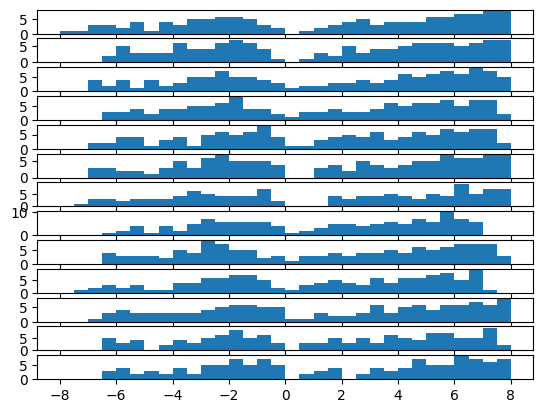

In [108]:
label = 0

fig, ax = plt.subplots(len(df[df.labels==label]), 1)

for i, index in enumerate(df[df.labels==label].index):
    ax[i].bar(edges[:-1], df.loc[index][fingerprint_cols], align="edge", width=edges[1]-edges[0])

plt.show()

## T-SNE Plot

In [89]:
n_components=2
tsne = manifold.TSNE(n_components=n_components, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=30 ,n_iter=10000, verbose=2)
fingerprints_2d = tsne.fit_transform(loaded_fingerprints)

NameError: name 'manifold' is not defined

In [90]:
fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2

plt.scatter(fingerprints_2d[:,0], fingerprints_2d[:,1],s=size, c=labels*5, cmap="turbo")

NameError: name 'fingerprints_2d' is not defined

<Figure size 800x800 with 0 Axes>